In [8]:
## importing various modules useful for this analysis

#--------fundamental modules-----
import os
import pandas as pd
import tqdm as tqdm
from scipy import stats
import numpy as np
import string

#-------visulizaiton modules-----

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import missingno as msno
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot,plot,init_notebook_mode
init_notebook_mode(connected= True)

import squarify
import geopandas as gpd

!pip install country_converter --upgrade
import country_converter as coco

from wordcloud import WordCloud, STOPWORDS


#______warningfilter module____________
import warnings
warnings.filterwarnings('ignore')

## setting pandas dataframe settings
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 2500)


### positioning all the plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
             display: table-cell;
             text-align: center;
             vertical-align: middle;
}
""")

In [10]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zezé Motta, Celso Frateschi",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi & Fantasy","In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor."
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, Azalia Ortiz, Octavio Michel, Carmen Beato",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies","After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive."
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence Koh, Tommy Kuan, Josh Lai, Mark Lee, Susan Leong, Benjamin Lim",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly, Christopher Plummer, Crispin Glover, Martin Landau, Fred Tatasciore, Alan Oppenheimer, Tom Kane",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi & Fantasy","In a postapocalyptic world, rag-doll robots hide in fear from dangerous machines out to exterminate them, until a brave newcomer joins the group."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aaron Yoo, Liza Lapira, Jacob Pitts, Laurence Fishburne, Jack McGee, Josh Gad, Sam Golzari, Helen Carey, Jack Gilpin",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-counting experts with the intent of swindling millions out of Las Vegas casinos by playing blackjack.


In [11]:
# basic information of the data
df.info(verbose = True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [19]:
df.describe(include=[object]).T.style.set_properties(**{'background-color': 'white',
                                                        'color': 'black',
                                                        'border-color': 'black',
                                                        'text-align': 'left'})


,count,unique,top,freq
show_id,7787,7787,s1,1
type,7787,2,Movie,5377
title,7787,7787,3%,1
director,5398,4049,"Raúl Campos, Jan Suter",18
cast,7069,6831,David Attenborough,18
country,7280,681,United States,2555
date_added,7777,1565,"January 1, 2020",118
rating,7780,14,TV-MA,2863
duration,7787,216,1 Season,1608
listed_in,7787,492,Documentaries,334


In [20]:
df.describe(include = [np.number]).T.style.set_properties(**{'background-color':'white',
                                     'color': 'black',
                                      'border-color':'black'})

,count,mean,std,min,25%,50%,75%,max
release_year,7787.000000,2013.932580,8.757395,1925.000000,2013.000000,2017.000000,2018.000000,2021.000000


This two tables gives some information about unique values, topvalues, frequencies of topvalues. Notably few features show some interesting stats

* type - 2 categroies, most of the content on the platform are movies.
* director - Raul Campos, Jan Suter are contirbuted and directed as many as 18 title, and they are by for on the top of the list. Sometimes people use this value to fill missing values, But we are not considering that option and stick with misisng values to director_data_unknown.
* cast- David Attenborough is the only actor to act in many of the films and shows on netflix. For filling missing values, we will use actor_data_unknown.
* country - USA is by far producing most of the content,so lets use this value to fillna values.
* date_added - jan 1 2020 is the peak date in content went online on platform. So, lets consider this to handle missing values.
* rating - 14 categories are present, so it make sense to analyise this data to see how are audience and what age group netflix targeting.
* listed_in - there are nearly 500 unique entries in this column, but we can split the data in to somekind of sting to see if we find anything interesting in here.
* release_year - this gives the chronoloical time line of produced content, here range of content is from 1925 to 2021, this could help us see how popular content from various years.
* descriptions - this could be helpful in understanding what kind of topics does content based on.

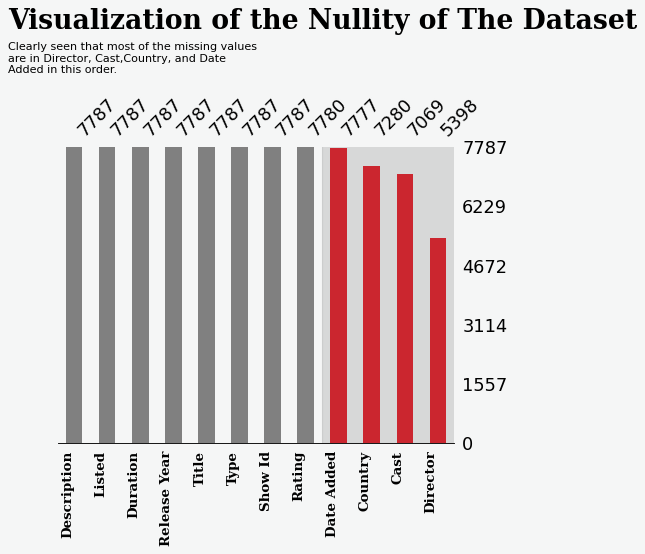

In [22]:
fig, ax = plt.subplots(dpi = 80)
ax.set_facecolor('#f5f6f6')
fig.patch.set_facecolor('#f5f6f6')

color = ['grey','grey','grey','grey','grey','grey','grey','grey','#E50914','#E50914','#E50914','#E50914']
msno.bar(df,fontsize =16, color = color, sort = 'descending', ax = ax, figsize = (12,6))
labels = ['Description','Listed','Duration', 'Release Year', 'Title', 'Type','Show Id','Rating', 'Date Added','Country', 'Cast','Director']
ax.set_xticklabels(labels, rotation=90, **{'font':'serif', 'color':'black', 'weight':'bold', 'size':12})

ax.text(-2,1.4,'Visualization of the Nullity of The Dataset' ,{'font':'serif', 'color':'black','weight':'bold','size':24})
ax.text(-2,1.25,'Clearly seen that most of the missing values \nare in Director, Cast,Country, and Date \nAdded in this order.')
ax.axvspan(7.5,12.5,0,7787, color = 'grey', alpha = 0.25)
ax.set_yticklabels('')
ax.spines['bottom'].set_visible(True)
fig.show()

Our missing number plots shows that total four columns have missing values which are director,rating, cast, country, date_added. Most of missing values canbe observed in director column, followed by cast column.

Strategy to fill this null values is a crutial step in building better ml models. Generally ml practitioners use range of techniques to solve this issue few are given below. Here null values in director, cast, country,rating, data_added

Three techniques to handle null values

   * .dropna() - This is a technique to drop the null values from dataset. This is quite useful if missing values are either quite less or we have ample of data.
   * .fillna() - This is a technique used to fillna value with either custom value or values from data stats. Filling techinque involves in filling na with mode of the column, filling forward value, filling backward value, or any custom value.
   * Third technique is quite advanced one, Where we make some assumption about missing values and use conditional statements to predict and fill the missing values from other feathers.

filling missing data with following datapoints

1. director - NoDataAvailable
2. cast - NoDataAvailable
3. county - mode of the county series
4. date_added - mode of the date_added
5. rating - mode of the rating

In [23]:
df_orig = df.copy() # copying original dataset 

# handling missing values
df['director'] = df['director'].fillna('NoDataAvailable')
df['country'] = df['country'].fillna(df['country'].mode()[0])
df['cast'] = df['cast'].fillna('NoDataAvailable')
df['date_added'] = df['date_added'].fillna(df['date_added'].mode()[0])
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])
print('count of values')
print(df.isna().sum())

count of values
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


There are 12 featues in dataset, data is moslty included with categorical data. Expected outcome from this EDA is to analyse some trends, tops bottoms of the data. Data in hand available is mostly categorical and time dependent components, so, strategy is to visualize few time dependencies, popular, unpopular of all the features. Crutial part of this analysis chronological inputs, so it's better to convert some dataframe columns to datetime format to extract month, year data from given crude data.

Along with the categorical and numerical data, we do have plenty of text data from descriptions, so there is nothing harm in looking what kind of topics does netflix content mostly based upon. Idea is to use wordcloud module to visulaize that word data.

Through out the anlysise to keep things simpler, tried to stick with best ink to area rules and no interactive plots to avoid mess. In addition as we are handling netflix data it would be fun to stick with the netflix brand palette, which is blacks, reds and white. lets start with brand palette visualization and move a head.

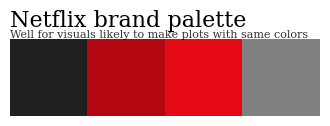

In [24]:
# Netflix brand colors
colors = ['#221f1f', '#b20710', '#e50914','grey']

#custom color palette
#customPalette = sns.set_palette(sns.color_palette(colors))
sns.palplot(colors,size = 1)
plt.title("Netflix brand palette ",loc='left',fontfamily= 'Serif',fontsize=16,y=1.05)
plt.text(-0.5,-0.52, 'Well for visuals likely to make plots with same colors',{'font':'serif', 'color':'black','weight':'normal','size':8}, alpha = 0.8 )
plt.axis('off')
fig.show()

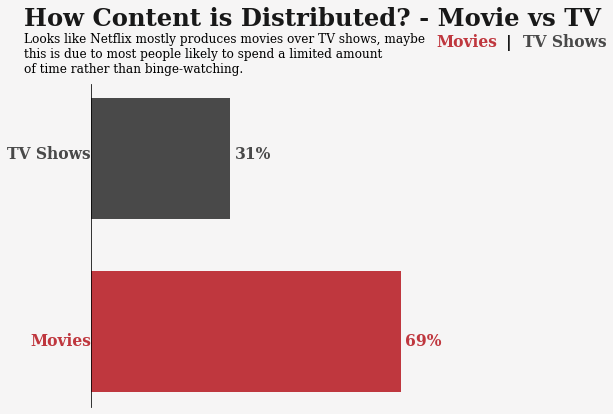

In [49]:
x = df['type'].value_counts()

# plot
fig, ax = plt.subplots(figsize = (6,6), dpi = 70)
ax.barh([1], x.values[1], height = 0.7, color = 'black', alpha = 0.7)
plt.text(-1450, 1, 'TV Shows', {'font': 'Serif', 'weight': 'bold', 'size': 16, 'style': 'normal', 'color': 'black'}, alpha=0.7)
plt.text(2500, 1, '31%', {'font': 'Serif', 'weight': 'bold', 'size': 16, 'color': 'black'}, alpha=0.7)


ax.barh([0], x.values[0], height = 0.7, color = '#b20710', alpha = 0.8)
plt.text(-1050, -0.08, 'Movies', {'font': 'Serif', 'weight': 'bold', 'size': 16, 'style': 'normal', 'color': '#b20710'}, alpha=0.8)
plt.text(5450, -0.08, '69%', {'font': 'Serif', 'weight': 'bold', 'size': 16, 'color': '#b20710'}, alpha=0.8)


fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

plt.text(-1150, 1.77, 'How Content is Distributed? - Movie vs TV', {'font': 'Serif', 'size': 25, 'weight': 'bold', 'color': 'black'}, alpha=0.9)
plt.text(6000, 1.65, 'Movies', {'font': 'Serif', 'weight': 'bold', 'size': 16, 'color': '#b20710'}, alpha=0.8)
plt.text(7200, 1.65, '|', {'color': 'black', 'size': 16, 'weight': 'bold'}, alpha=0.9)
plt.text(7500, 1.65, 'TV Shows', {'font': 'Serif', 'weight': 'bold', 'size': 16, 'color': 'black'}, alpha=0.7)
plt.text(-1150, 1.5, 'Looks like Netflix mostly produces movies over TV shows, maybe \nthis is due to most people likely to spend a limited amount \nof time rather than binge-watching.', 
                    {'font': 'Serif', 'size': 12.5, 'color': 'black'})


ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Neflix offer two kinds of streaming content, whicha are movies and Tv shows. Distribution of the content on platform is skewed towards to movies, which occupy nearly 70 percent of the content it offer. Our distribution pie shows the stats of content from the data. So, this feature is important while anlysis other features.

In given dataset, overall 14 categories of maturity ratings can be seen, which provide relevence of content to various age groups and in general for kids, teens, and adults. This rating help in reccomending appropriate content to appropriate age groups. It is not suggestable for kids to Withcher, right? like wise adults less likely to watch naruto. So, this is a very important parameter for a best reccomendation system, which is why little emphasis was provided over this column.

To make things simpler whole, 14 categories were split into three age groups:kids, Teens, Adults based on information from netflix help

Maturity rating can be found at the above link

TV-Y : Kids
TV-Y7 : Kids
TV-G : Kids
PG : Kids
TV-PG : Kids
PG-13 : Teens
TV-14 : Teens
R : Adults
TV-MA : Adults
NC-17 : Adults
NR : Adults
UR : Adults
TV-Y7-FV : Kids
G : Kids
These are maturity wise classification

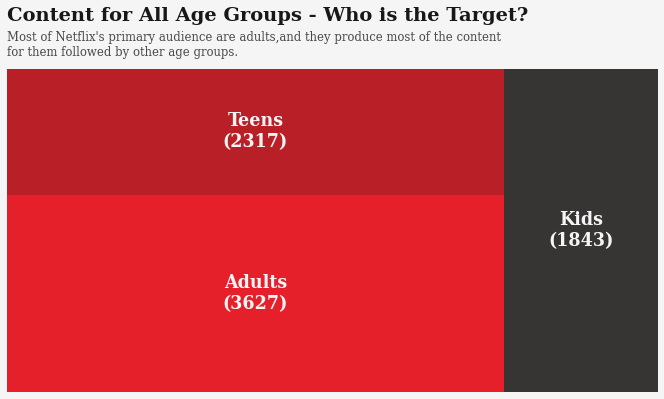

In [46]:
rating = {'TV-Y': 'Kids',
          'TV-Y7': 'Kids',
          'TV-G': 'Kids',
          'PG': 'Kids',
          'TV-PG': 'Kids',
          'PG-13': 'Teens',
          'TV-14': 'Teens',
          'R': 'Adults',
          'TV-MA': 'Adults',
          'NC-17': 'Adults',
          'NR': 'Adults',
          'UR': 'Adults',
          'TV-Y7-FV': 'Kids',
          'G': 'Kids'}

# Creating a new column with age rating
df['age_rating'] = df['rating'].replace(to_replace=rating)

age_ratings = df['age_rating'].value_counts()

labels = [str(idx) + "\n(" + str(val) + ")" for idx, val in age_ratings.items()]

fig, ax = plt.subplots(figsize=(12, 6), dpi=70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

squarify.plot(sizes=age_ratings.values, label=labels,
              color=['#e50914', '#b20710', '#221f1f'],
              ax=ax, text_kwargs={'font': 'serif', 'fontsize': 18, 'color': '#f6f5f5', 'weight': 'bold'},
              alpha=0.9)

ax.text(0, 114.8, 'Content for All Age Groups - Who is the Target?', {'font': 'serif', 'fontsize': 20, 'color': 'black', 'weight': 'bold'}, alpha=0.9)
ax.text(0, 104, 'Most of Netflix\'s primary audience are adults,and they produce most of the content \nfor them followed by other age groups.', {'font': 'serif', 'fontsize': 12, 'color': 'black', 'weight': 'normal'}, alpha=0.7)

ax.axis('off')
plt.show()

From the treemap visulaization, it is clear that most of the netflix content is for adults followed by teens and kids. In general this making sense as well, so lets focus on rating distribution entirely this time, to see understand deeply which sub categories are on top of the list and which are at the bottom of the list.

Trying to implement less ink to chart area ratio principal here

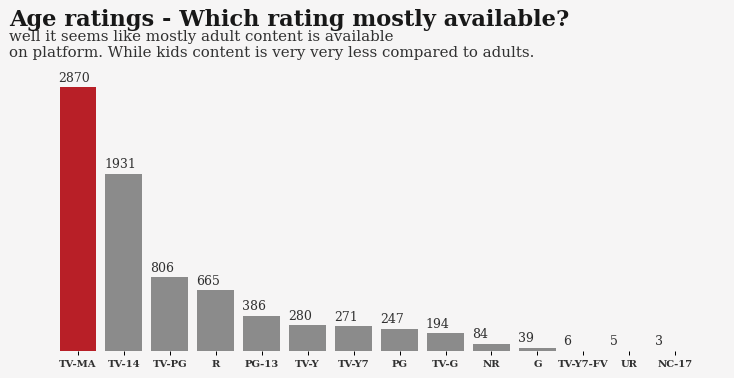

In [51]:
fig, ax = plt.subplots(figsize = (10,4), dpi = 90)
ax.set_facecolor('#f6f5f5')
fig.patch.set_facecolor('#f6f5f5')

a = df['rating'].value_counts()
colors = ['#b20710','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey']
ax.bar(x = a.index, height = a.values, color = colors, alpha = 0.9)

# Create labels
label = a.values.tolist()
 
# Text on the top of each bar
for i in range(len(label)):
    x = i  - 0.35
    y = (i+18)/2 + label[i]
    x = x-0.08
    y = y + 52
    ax.text(x,y, '{}'.format(a.values[i]),{'font': 'serif', 'weight': 'normal', 'color': 'black', 'fontsize': 10}, alpha = 0.8)

#ax.set_xticks(a.values)
ax.text(-1.5,3540, 'Age ratings - Which rating mostly available?', {'font': 'serif', 'color': 'black', 'fontsize': 18, 'weight':'bold'},alpha = 0.9 )
ax.text(-1.5,3200, 'well it seems like mostly adult content is available \non platform. While kids content is very very less compared to adults. ', {'font': 'serif', 'color': 'black', 'fontsize': 12,},alpha = 0.8)

for loc in ['left','right','top','bottom']:
    ax.spines[loc].set_visible(False)
    
ax.set_xticklabels(a.index, fontdict={'font': 'serif', 'color': 'black', 'fontsize': 8, 'weight': 'bold'}, alpha=0.8)
ax.axes.get_yaxis().set_visible(False)
fig.show()

From rating count bar chart, it is clear that most of the content is produced for adults and teens. Very less general content is available online on netflix.

In our data, two features are chronological data, which are date_added, release_year. Why is this data important? okay, lets make an assumption that, analysing content added date could help us understand which month of the year done most of the content added to the platform and pace of adding content to platform with time. Release_year could help understanding the influence of the digital era over the content production in either direct or indirect way. So, lets start our analysis.

Always its better to convert dataframe to todatetime format when dealing with time series.

In [53]:
# converting the pandas dataframe to datatime format
df['date_added'] = pd.to_datetime(df['date_added'], errors = 'coerce')
df['added_year'] = df['date_added'].dt.year
df['added_month'] = df['date_added'].dt.month
df['added_month_name'] = df['date_added'].dt.month_name()


# creating a series of time data

add_year = df['added_year'].value_counts()
release = df['release_year'].value_counts()

# creating a dataframe

add_df = pd.DataFrame({'year': add_year.index, 'added_year': add_year.values})
release_df = pd.DataFrame({'year': release.index, 'release_year': release.values})

year_df = pd.merge(add_df, release_df, how = 'right', on = 'year')
year_df.fillna('0', inplace = True)
year_df['added_year'] = year_df.added_year.astype('int')

year_df = year_df.sort_values('year', ascending = False).reset_index(drop = True)

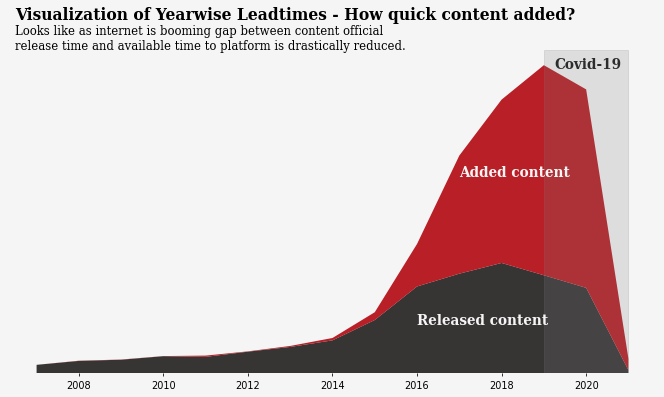

In [61]:
## visulaization

fig, ax = plt.subplots(figsize = (12,6), dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

labels = [ 'Released content', 'Added content ']

# stackplot
ax.stackplot(year_df.year[0:15], year_df.release_year[0:15],year_df.added_year[0:15],labels =labels, 
              colors = ['#221f1f','#b20710',], baseline = 'zero', alpha = 0.9 )

# Region of interest
 
ax.axvspan(2019,2021, color = 'grey',alpha = 0.2)
ax.text(2019.25, 3100, 'Covid-19', {'font':'serif', 'fontsize': '14', 'color': 'black', 'weight':'bold'},alpha = 0.8)

# legend
ax.text(2017, 2000, '{}'.format(labels[1]), {'font': 'serif', 'fontsize': 14, 'color': '#f6f5f5', 'weight': 'bold'})
ax.text(2016, 500, '{}'.format(labels[0]), {'font': 'serif', 'fontsize': 14, 'color': '#f6f5f5', 'weight': 'bold'}) 

#title
 
ax.text(2006.5, 3600, 'Visualization of Yearwise Leadtimes - How quick content added?', 
        {'font':'serif', 'fontsize':16, 'weight': 'bold', 'color': 'black'})
ax.text(2006.5, 3290, 'Looks like as internet is booming gap between content official \nrelease time and available time to platform is drastically reduced. ',
        {'font':'serif', 'fontsize':12, 'color': 'black'})

plt.box(on = None)

ax.axes.get_yaxis().set_visible(False)
fig.show()

Data tells a better story, isn't it? looking at the above plots it is obvious that since last decade, content addition to netflix is far higher than released. This is may be because streaming platforms are adding old content as well in parallel to current production. This Trend is true since the boon of internet era as mosty of the content reach one or other steaming platform. From our plot, impact of recent covid-19 pandemic on content release and content addtion can be observed, which is from end 2019 to 2021. Highest number of movies and shows were added around 2020 and lowest of lowest could be seen at the tail section.

In [62]:
TV = df[df['type'] == 'TV Show'].release_year.value_counts()
Movie = df[df['type'] == 'Movie'].release_year.value_counts()

# creating a dataframe

Tv_df = pd.DataFrame({'year': TV.index, 'Tv_count': TV.values})
Movie_df = pd.DataFrame({'year': Movie.index, 'Movie_count': Movie.values})

rel_data = pd.merge(Tv_df, Movie_df, how = 'right', on = 'year')
rel_data.fillna('0', inplace = True)
rel_data['Tv_count'] = rel_data.Tv_count.astype('int64')
rel_data = rel_data.sort_values('year', ascending = False).reset_index(drop = True)

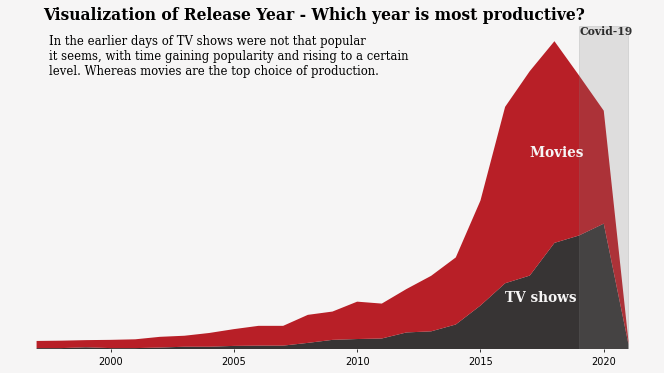

In [65]:
## visulaization

fig, ax = plt.subplots(figsize = (12,6), dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

labels = [ 'TV shows', 'Movies ']

# stackplot
ax.stackplot(rel_data.year[0:25], rel_data.Tv_count[0:25],rel_data.Movie_count[0:25],labels =labels, 
              colors = ['#221f1f','#b20710',], baseline = 'zero', alpha = 0.9 )

# Region of interest
 
ax.axvspan(2019,2021, color = 'grey',alpha = 0.2)
ax.text(2019, 1147, 'Covid-19', {'font':'serif', 'fontsize': '11', 'color': 'black', 'weight':'bold'},alpha = 0.8)

# legend
ax.text(2017, 700, '{}'.format(labels[1]), {'font':'serif', 'fontsize':14, 'color':'#f6f5f5', 'weight':'bold'})
ax.text(2016, 175, '{}'.format(labels[0]), {'font':'serif', 'fontsize':14, 'color':'#f6f5f5', 'weight':'bold'}) 

#title
 
ax.text(1997.25,1200, 'Visualization of Release Year - Which year is most productive?', {'font':'serif', 'fontsize':16, 'weight': 'bold','color': 'black'})
ax.text(1997.5,1000, 'In the earlier days of TV shows were not that popular \nit seems, with time gaining popularity and rising to a certain \nlevel. Whereas movies are the top choice of production.', {'font':'serif', 'fontsize':12,'color': 'black'})

plt.box(on = None)

ax.axes.get_yaxis().set_visible(False)
fig.show()

Release of content was happening from way back 1925, but here that data was truncated as it is out of scope of this anlayis. From the plot it is clear that entertainment industry mostly favoured movies till last decade, but things are changing and focus shifting towards shows as well. It is clear from the plot that covid did effected entertaiment industry significataly. Since past decade, both movies and tv shows gain popularity and most of the content is in the category of movies.

In [66]:
TV = df[df['type'] == 'TV Show'].added_year.value_counts()
Movie = df[df['type'] == 'Movie'].added_year.value_counts()

# creating a dataframe

Tv_df = pd.DataFrame({'year': TV.index, 'Tv_count': TV.values})
Movie_df = pd.DataFrame({'year': Movie.index, 'Movie_count': Movie.values})

add_data = pd.merge(Tv_df, Movie_df, how = 'right', on = 'year')
add_data.fillna('0', inplace = True)
add_data['Tv_count'] = add_data.Tv_count.astype('int64')
add_data = add_data.sort_values('year', ascending = False).reset_index(drop = True)

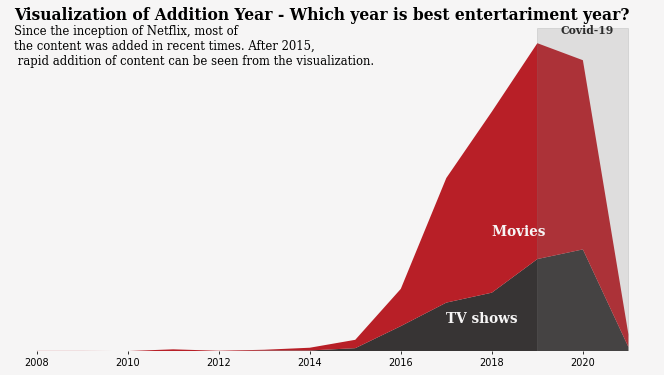

In [72]:
## visulaization

fig, ax = plt.subplots(figsize = (12,6), dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

labels = [ 'TV shows', 'Movies ']

# stackplot
ax.stackplot(add_data.year[0:25], add_data.Tv_count[0:25],add_data.Movie_count[0:25],labels =labels, 
              colors = ['#221f1f','#b20710',], baseline = 'zero', alpha = 0.9 )

# Region of interest
 
ax.axvspan(2019,2021, color = 'grey',alpha = 0.2)
ax.text(2019.5, 2200, 'Covid-19', {'font':'serif', 'fontsize': 11, 'color': 'black', 'weight':'bold'}, alpha=0.8)

#Legend
ax.text(2018, 800, '{}'.format(labels[1]), {'font':'serif', 'fontsize':14, 'color':'#f6f5f5', 'weight':'bold'})
ax.text(2017, 200, '{}'.format(labels[0]), {'font':'serif', 'fontsize':14, 'color':'#f6f5f5', 'weight':'bold'}) 

#title
 
ax.text(2007.5, 2300, 'Visualization of Addition Year - Which year is best entertariment year?',
        {'font': 'serif', 'fontsize': 16, 'weight': 'bold', 'color': 'black'})
ax.text(2007.5, 1990, 'Since the inception of Netflix, most of \nthe content was added in recent times. After 2015,\n rapid addition of content can be seen from the visualization.',
        {'font': 'serif', 'fontsize': 12, 'color': 'black'})

plt.box(on = None)

ax.axes.get_yaxis().set_visible(False)
fig.show()

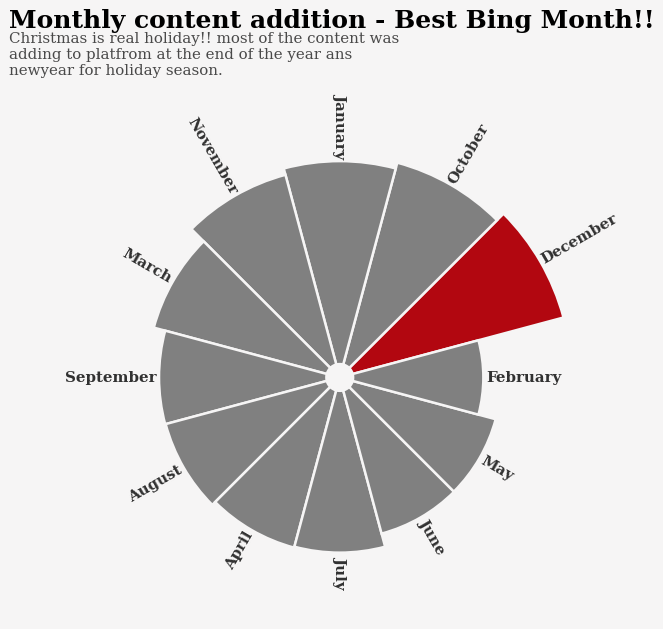

In [73]:
added_month = df['added_month'].value_counts()

# initialize the figure
fig = plt.figure(figsize=(14,7), dpi = 90)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
ax = plt.subplot(polar=True)
plt.axis('off')


## labels
label_map = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
lab = added_month.index
labels = lab.map(label_map)

colors = ['#b20710', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey','grey']


# Constants = parameters controling the plot layout:
upperLimit = 1000
lowerLimit = 50
labelPadding = 10

# Compute max and min in the dataset
max = added_month.max()

slope = (max - lowerLimit) / max
heights = slope * added_month.values + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(added_month.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(added_month)+1))
angles = [element * width for element in indexes]


# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="#f6f5f5",
    color = colors,
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, labels):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle,
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",**{'font':'serif', 'size':12, 'weight':'bold','color':'black'},alpha = 0.8) 

fig.text(0.25,1.05,'Monthly content addition - Best Bing Month!!',{'font':'serif', 'size':20, 'weight':'bold','color':'black'})
fig.text(0.25,0.975,'Christmas is real holiday!! most of the content was \nadding to platfrom at the end of the year ans \nnewyear for holiday season.',{'font':'serif', 'size':12,'color':'black'}, alpha = 0.7)
fig.show()

From the plot above it is clear that in the month of january, december most of the content went online. It is good to observe that most of the content start available in holiday season, like march, just befro summer and like wise in december.

In [74]:
country = df.country.value_counts()

coun = {}
for idx, val in country.items():
    l = idx.split(',')
    for i in l:
        i = i.strip()
        if i in coun.keys():
            d = {}
            d[i] = val + coun[i]
            coun.update(d)
        else:
            d = {i:val}
            coun.update(d)

nation, count = [],[]
for idx, val in coun.items():
    nation.append(idx)
    count.append(val)

temp = (pd.DataFrame({'country':nation, 'count': count})
        .sort_values('count', ascending = False))

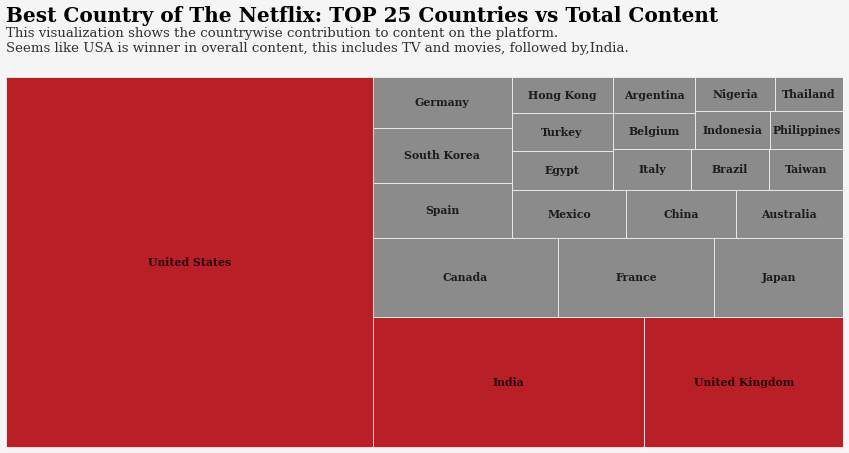

In [75]:
temp['color'] = temp['count'].apply(lambda x : '#b20710' if x > temp['count'].values[3] else 'grey')
# visulaization
fig, ax = plt.subplots(figsize = (18,8), dpi = 60)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

bar_kawrgs = {'edgecolor':'#f6f5f5'}
squarify.plot(sizes= temp['count'][0:24], label = temp['country'][0:24], ax = ax, color = temp['color'],  **bar_kawrgs,
             text_kwargs = {'font':'serif', 'size':13, 'color':'black', 'weight':'bold', 'alpha':0.8},alpha = 0.9)

ax.text(0,115,'Best Country of The Netflix: TOP 25 Countries vs Total Content',{'font':'serif', 'size':24, 'color':'black', 'weight':'bold'}, alpha = 1)
ax.text(0,107, 'This visualization shows the countrywise contribution to content on the platform. \nSeems like USA is winner in overall content, this includes TV and movies, followed by,India.',
       {'font':'serif', 'size':16, 'color':'black'}, alpha = 0.8)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

for loc in ['left','right','top', 'bottom']:
    ax.spines[loc].set_visible(False)

fig.show()

West Germany not found in regex
 not found in regex
Soviet Union not found in regex
East Germany not found in regex


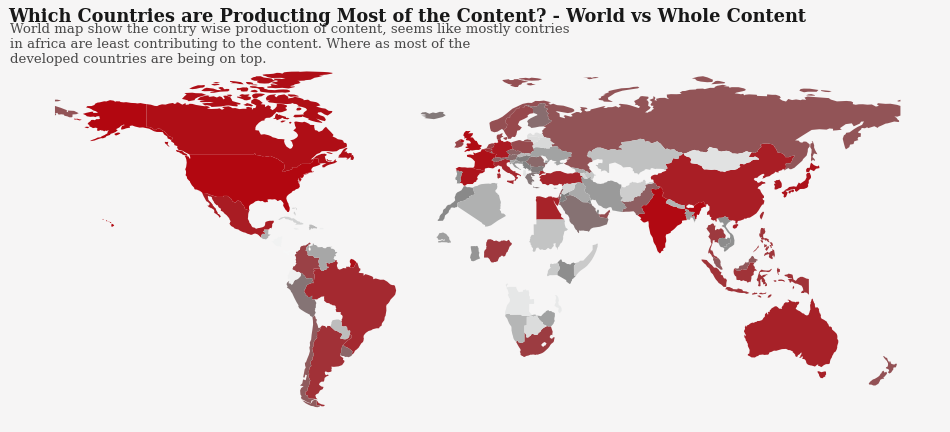

In [76]:
temp['color'] = temp['count'].apply(lambda x : '#b20710' if x > temp['count'].values[30] else 'grey')

#loading geodataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#converting country names to iso codes
temp['iso_code'] = coco.convert(names=temp['country'], to ='ISO3')
temp = temp[temp['iso_code'] != 'not found']

# merging geodataframe and pandas dataframe
temp_map = world.merge(temp,left_on = 'iso_a3', right_on = 'iso_code')

temp_map.drop(columns = ['continent', 'gdp_md_est','pop_est','name',], inplace = True)
temp_map = temp_map.sort_values(by = 'count', ascending = False)


#viualization
colors = ['#b20710','grey','#f8f9f9',]
cmap  = matplotlib.colors.LinearSegmentedColormap.from_list("", colors = colors)

fig, ax  = plt.subplots(figsize = (15,7.5), dpi = 80)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
temp_map.dropna().plot(column = 'count', 
                       color = temp_map.dropna()['color'], 
                       cmap = cmap,
                       scheme='quantiles', 
                       k=10, legend = False,
                       ax = ax)

for loc in ['left','right','top','bottom']:
    ax.spines[loc].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.text(-200,104,'Which Countries are Producting Most of the Content? - World vs Whole Content', {'font':'serif', 'size':16, 'weight':'bold'}, alpha = 0.9)
ax.text(-199,87,'World map show the contry wise production of content, seems like mostly contries \nin africa are least contributing to the content. Where as most of the \ndeveloped countries are being on top.', {'font':'serif', 'size':12}, alpha = 0.7)
fig.show()

These visulizations show the countrywise count of origin of content, which include both Movies and TVs shows. US and India are on top of the list. few countries from africa has very low production of netflix content. Okay, lets analyze content seperately for TVshows and Movies to see which country favours to what type of content most.

Why it is important to seperate country wise content preference?

Because not every region same kind of content, like indian prefer to watch movie over TV shows, on contrary south koreans perfer Tv shows over movies. We are interested in finding such perferential choices. Now lets analyse the data based on content and country data.

Two type of categories araise here

1. TV shows prefered countries
2. Movies shows prefered countries

In [77]:
## Movies countrywise distribution

Movies = df[df['type'] == 'Movie']


Movi_country = Movies.country.value_counts()

Movi_coun = {}
for idx, val in Movi_country.items():
    l = idx.split(',')
    for i in l:
        i = i.strip()
        if i in Movi_coun.keys():
            d = {}
            d[i] = val + Movi_coun[i]
            Movi_coun.update(d)
        else:
            d = {i:val}
            Movi_coun.update(d)

Movi_nation, Movi_count = [],[]
for idx, val in Movi_coun.items():
    Movi_nation.append(idx)
    Movi_count.append(val)

Movi_temp = (pd.DataFrame({'country':Movi_nation, 'count': Movi_count})
        .sort_values('count', ascending = False))

Movi_temp['color'] = Movi_temp['count'].apply(lambda x : '#b20710' if x > Movi_temp['count'].values[3] else 'grey')

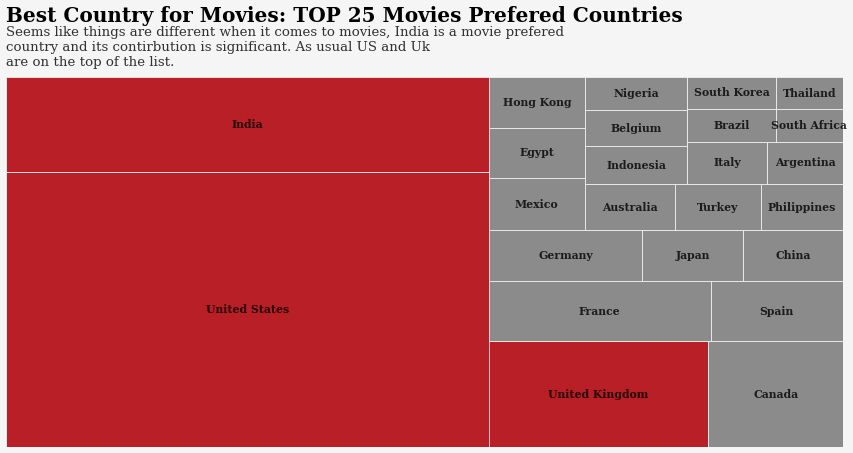

In [78]:
# visulaization
fig, ax = plt.subplots(figsize = (18,8), dpi = 60)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

bar_kawrgs = {'edgecolor':'#f6f5f5'}
squarify.plot(sizes= Movi_temp['count'][0:24], label = Movi_temp['country'][0:24], ax = ax, color = Movi_temp['color'],  **bar_kawrgs,
             text_kwargs = {'font':'serif', 'size':13, 'color':'black', 'weight':'bold', 'alpha':0.8},alpha = 0.9)

ax.text(0,115,'Best Country for Movies: TOP 25 Movies Prefered Countries ',{'font':'serif', 'size':24, 'color':'black', 'weight':'bold'}, alpha = 1)
ax.text(0,103, 'Seems like things are different when it comes to movies, India is a movie prefered \ncountry and its contirbution is significant. As usual US and Uk \nare on the top of the list.',
       {'font':'serif', 'size':16, 'color':'black'}, alpha = 0.8)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

for loc in ['left','right','top', 'bottom']:
    ax.spines[loc].set_visible(False)

fig.show()

 not found in regex
Soviet Union not found in regex
West Germany not found in regex
East Germany not found in regex


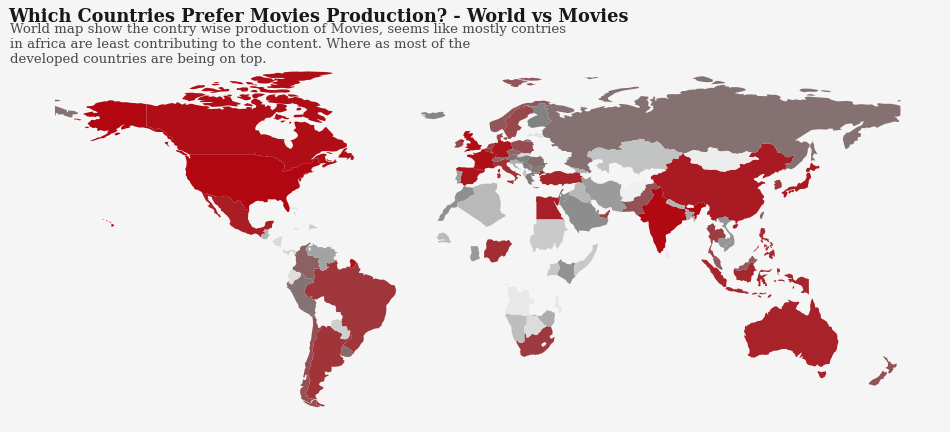

In [79]:
temp = Movi_temp
temp['color'] = temp['count'].apply(lambda x : '#b20710' if x > temp['count'].values[30] else 'grey')

#loading geodataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#converting country names to iso codes
temp['iso_code'] = coco.convert(names=temp['country'], to ='ISO3')
temp = temp[temp['iso_code'] != 'not found']

# merging geodataframe and pandas dataframe
temp_map = world.merge(temp,left_on = 'iso_a3', right_on = 'iso_code')

temp_map.drop(columns = ['continent', 'gdp_md_est','pop_est','name',], inplace = True)
temp_map = temp_map.sort_values(by = 'count', ascending = False)


#viualization
colors = ['#b20710','grey','#f8f9f9',]
cmap  = matplotlib.colors.LinearSegmentedColormap.from_list("", colors = colors)

fig, ax  = plt.subplots(figsize = (15,7.5), dpi = 80)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
temp_map.dropna().plot(column = 'count', 
                       color = temp_map.dropna()['color'], 
                       cmap = cmap,
                       scheme='quantiles', 
                       k=10, legend = False,
                       ax = ax)

for loc in ['left','right','top','bottom']:
    ax.spines[loc].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.text(-200,104,'Which Countries Prefer Movies Production? - World vs Movies', {'font':'serif', 'size':16, 'weight':'bold'}, alpha = 0.9)
ax.text(-199,87,'World map show the contry wise production of Movies, seems like mostly contries \nin africa are least contributing to the content. Where as most of the \ndeveloped countries are being on top.', {'font':'serif', 'size':12}, alpha = 0.7)
fig.show()

What is interantional content? It is content shooted or produced in may countries as a colloborative project. Many of the TV shows and movies are produced internationaly. So it is important to analyse this data well.

International or not

1. International - 1
2. Domestic - 0

In [80]:
content = df[['type', 'country']]
content['num_countries'] = content['country'].apply(lambda x: len(x.split(',')))
content['International'] = content['num_countries'].apply(lambda x: 1 if x>1 else 0)
dom = content[content['International'] == 0]['type'].value_counts()
inter = content[content['International'] == 1]['type'].value_counts()

inter = content[content['International'] == 1]
dom = content[content['International'] == 0]

inter_t = inter.groupby('type')['International'].count()
dom_t = dom.groupby('type')['International'].count()

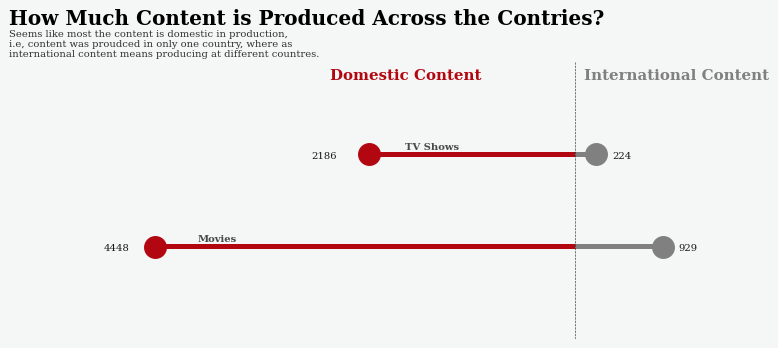

In [81]:
fig,ax = plt.subplots(figsize = (8,4), dpi = 90)
fig.patch.set_facecolor('#f5f6f6')
ax.set_facecolor('#f5f6f6')

ax.barh(y = inter_t.index, width = inter_t.values, height = 0.05, color = ['grey'])
ax.scatter(y = inter_t.index,x=inter_t.values, s = 300,c = ['grey'])
ax.barh(y = dom_t.index, width = - dom_t.values, height = 0.05, color = ['#b20710'],alpha = 1)
ax.scatter(y = dom_t.index,x = - dom_t.values, s = 300,c = ['#b20710'], alpha =1)

ax.axvline(x = 0, ymin = -0.25,ymax=1, **{'color':'black', 'linewidth':0.5, 'linestyle':'--'},alpha = 0.8)



ax.text(-1800,1.05, 'TV Shows', {'font':'serif','weight':'bold', 'size':8}, alpha = 0.7)
ax.text(-2800,0.95, dom_t.values[1], {'font':'serif', 'size':8}, alpha = 0.9)
ax.text(-5000,-0.05, dom_t.values[0], {'font':'serif', 'size':8}, alpha = 0.9)



ax.text(-4000,0.05, 'Movies', {'font':'serif','weight':'bold', 'size':8}, alpha = 0.7)
ax.text(400,0.95, inter_t.values[1], {'font':'serif', 'size':8}, alpha = 0.9)
ax.text(1100,-0.05, inter_t.values[0], {'font':'serif', 'size':8}, alpha = 0.9)

ax.set_ylim([-1,2])



ax.text(-2600,1.8, 'Domestic Content', {'font':'serif','weight':'bold', 'color':'#b20710','size':12}, alpha = 1)
ax.text(100,1.8, 'International Content', {'font':'serif','weight':'bold', 'color':'grey','size':12}, alpha = 1)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

for loc in ['left','right','top','bottom']:
    ax.spines[loc].set_visible(False)


ax.text(-6000, 2.4, 'How Much Content is Produced Across the Contries?',{'font':'serif','weight':'bold', 'color':'black','size':16}, alpha = 1)
ax.text(-6000, 2.05, 'Seems like most the content is domestic in production, \ni.e, content was proudced in only one country, where as \ninternational content means producing at different countres.',{'font':'serif', 'color':'black','size':8}, alpha = 0.8)
    
fig.show()

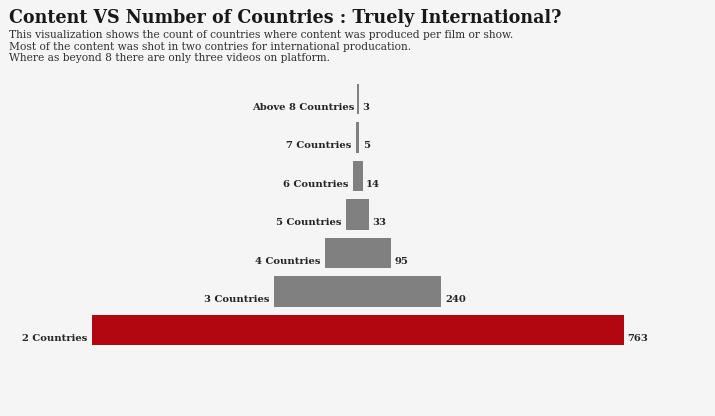

In [82]:
num_countries = content['num_countries'].value_counts()

fig, ax = plt.subplots(figsize = (10,5),dpi = 90)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

###bars left
color = ['#b20710','grey','grey','grey','grey','grey','grey']
ax.barh(y =  num_countries[1:-2].index  , width =num_countries[1:-2].values,  height = 0.8,color =color )
ax.barh(y =  8  , width = 3,  height = 0.8,color = 'grey')
#bars right
ax.barh(y =  num_countries[1:-2].index  , width = -num_countries[1:-2].values,  height = 0.8,color = color)
ax.barh(y =  8 , width = - 3,  height = 0.8,color = 'grey')


for i,j in num_countries.items():
    if (i >1 and i < 8):
        ax.text(j+10,i - 0.25, j, {'font':'serif', 'size':8, 'color':'black','weight':'bold'}, alpha = 0.85)
        ax.text(- (j+200),i -0.25,'{} Countries'.format(i), {'font':'serif', 'size':8, 'color':'black','weight':'bold'}, alpha = 0.85)
        
    if i == 8:
        ax.text(3 +10,i-0.25,3, {'font':'serif', 'size':8, 'color':'black','weight':'bold'}, alpha = 0.85)
        ax.text(- (3 +300),i-0.25,'Above 8 Countries', {'font':'serif', 'size':8, 'color':'black','weight':'bold'}, alpha = 0.85)
        

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

for loc in ['left','right','top','bottom']:
    ax.spines[loc].set_visible(False)

#plt.title('Number of contries for international content count plot')
ax.set_xlim([-1000,1000])
ax.set_ylim([0,9])

ax.text(- 1000, 10, 'Content VS Number of Countries : Truely International?',{'font':'serif', 'size':14, 'color':'black','weight':'bold'}, alpha = 0.9)
ax.text(-1000,9, 'This visualization shows the count of countries where content was produced per film or show. \nMost of the content was shot in two contries for international producation. \nWhere as beyond 8 there are only three videos on platform.',
       {'font':'serif', 'size':8.5, 'color':'black'}, alpha = 0.8)
fig.show()

Netflix offer range of genre to subsribers, for comdeies to tragedy , documnetaries to talk shows, It would be fun to analyze this feature. One interesting thing to notice is that most of the content fells into to multiple genre so, we can visulaize single genre contet and multiple genre content as well.

With little data cleaing we find that there are total of only 42 genre on netflix, but all the content fell into multi genre,which makes a big mess to visulaize the data.

In [83]:
## genere count 

def genere(what):
    if what == 'all':
        genere = df.listed_in.value_counts()
    else:
        genere = df[df['type'] == what].listed_in.value_counts()
    gener = {}
    
    for idx, val in genere.items():
        l = idx.split(',')
        for i in l:
            i = i.strip()
            if i in gener.keys():
                d = {}
                d[i] = val + gener[i]
                gener.update(d)
            else:
                d = {i:val}
                gener.update(d)
    theme, count = [],[]
    
    for idx, val in gener.items():
        theme.append(idx)
        count.append(val)
    
    list_temp = (pd.DataFrame({'genere':theme, 'count': count})
        .sort_values('count', ascending = True))
    list_temp.reset_index(drop = True, inplace = True)
    
    return list_temp
tv_genere = genere('TV Show')
mov_genere = genere('Movie')

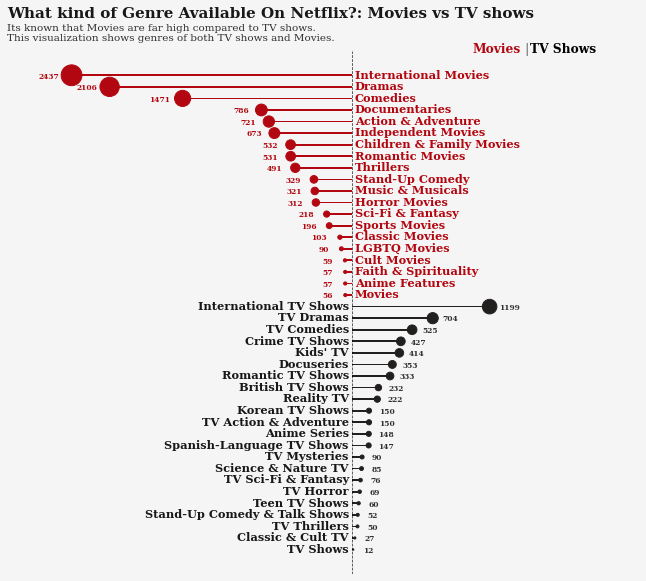

In [84]:
fig, ax  = plt.subplots(figsize = (12,10), dpi =68)

colors = ['#b20710']
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

ax.barh( y = tv_genere['genere'], width = tv_genere['count'], height = 0.15, color = ['#221f1f'])
ax.scatter( y = tv_genere['genere'], x =  tv_genere['count'], s = tv_genere['count'] * 0.2, c = '#221f1f')

ax.barh( y = mov_genere['genere'], width = - mov_genere['count'], height = 0.15, color = ['#b20710'])
ax.scatter( y = mov_genere['genere'], x =  -mov_genere['count'], s=mov_genere['count']*0.2 , c = '#b20710')

ax.axvline(x = 0, ymin = 0, ymax = 1, **{'linewidth':0.8, 'linestyle': '--', 'color' : 'black'}, alpha = 0.8)

tv_index = tv_genere['genere']
mov_index = mov_genere['genere']

tv_count = tv_genere['count']
mov_count = mov_genere['count']

for y_loc in range(0,22):
        ax.text(-25, y_loc - 0.25 , tv_index[y_loc],horizontalalignment= 'right',**{'font':'serif', 'size':12, 'weight':'bold', 'color':'black'}, alpha = 0.9)
        ax.text(tv_count[y_loc] + 85, y_loc - 0.25, tv_count[y_loc],horizontalalignment= 'left',**{'font':'serif', 'size':8, 'weight':'bold', 'color':'black'}, alpha = 0.8)
        
        
for y_loc in range(0,20):
        ax.text(25, 22+y_loc - 0.25, mov_index[y_loc],horizontalalignment = 'left',**{'font':'serif', 'size':12, 'weight':'bold', 'color':'#b20710'}, alpha =1)
        ax.text(-mov_count[y_loc] - 110,  22 + y_loc - 0.25 , mov_count[y_loc],horizontalalignment= 'right',**{'font':'serif', 'size':8, 'weight':'bold', 'color':'#b20710'}, alpha =1)
    
for loc in ['left', 'right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.set_xlim([-3000,2500])

ax.text(-3000, 46, 'What kind of Genre Available On Netflix?: Movies vs TV shows',{'font':'serif', 'size':16, 'weight':'bold', 'color':'black'}, alpha = 0.9)
ax.text(-3000, 44, 'Its known that Movies are far high compared to TV shows. \nThis visualization shows genres of both TV shows and Movies.',{'font':'serif', 'size':11, 'color':'black'}, alpha = 0.8)

ax.text(1050, 43, 'Movies',{'font':'serif', 'size':13, 'color':'#b20710', 'weight':'bold'}, alpha = 1)
ax.text(1500, 43, '|',{'font':'serif', 'size':13, 'color':'grey','weight':'bold'}, alpha = 1)
ax.text(1550, 43, 'TV Shows',{'font':'serif', 'size':13, 'color':'black', 'weight':'bold'}, alpha = 1)

fig.show()

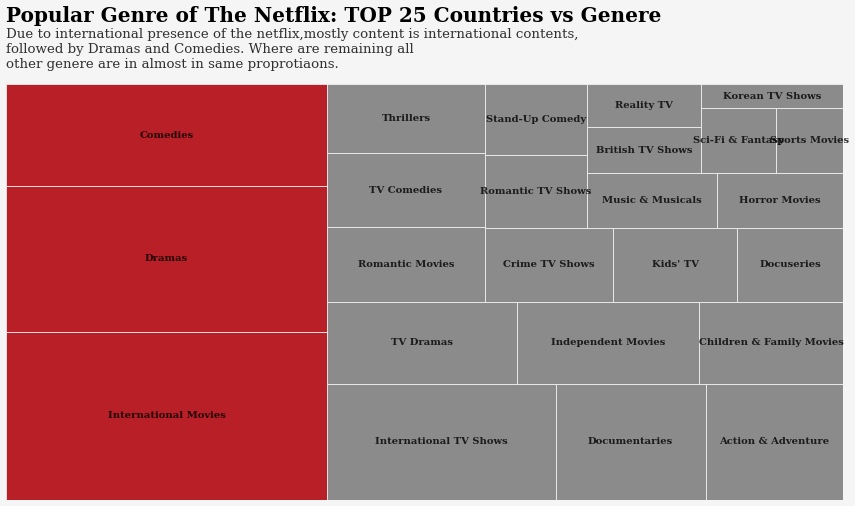

In [167]:
list_temp = genere('all')
list_temp = list_temp.sort_values(by = 'count', ascending = False).reset_index(drop = True)
list_temp['color'] = list_temp['count'].apply(lambda x : '#b20710' if x > list_temp['count'].values[3] else 'grey')
# visulaization
fig, ax = plt.subplots(figsize = (18,9), dpi = 60)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

bar_kawrgs = {'edgecolor':'#f6f5f5'}
squarify.plot(sizes= list_temp['count'][0:24], label = list_temp['genere'][0:24], ax = ax, color = list_temp['color'],  **bar_kawrgs,
             text_kwargs = {'font':'serif', 'size':12, 'color':'black', 'weight':'bold', 'alpha':0.8},alpha = 0.9)

ax.text(0,115,'Popular Genre of The Netflix: TOP 25 Countries vs Genere',{'font':'serif', 'size':24, 'color':'black', 'weight':'bold'}, alpha = 1)
ax.text(0,104, 'Due to international presence of the netflix,mostly content is international contents, \nfollowed by Dramas and Comedies. Where are remaining all \nother genere are in almost in same proprotiaons.',
       {'font':'serif', 'size':16, 'color':'black'}, alpha = 0.8)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

for loc in ['left','right','top', 'bottom']:
    ax.spines[loc].set_visible(False)

fig.show()

In [86]:
listed_type = df[['type', 'listed_in']]

listed_type['num_genre'] = listed_type['listed_in'].apply(lambda x: len(x.split(',')))
listed_type['multi_genre'] = listed_type['num_genre'].apply(lambda x: 1 if x > 2 else 0)

listed_type.drop(columns = ['listed_in'], inplace = True)

tv_multi = listed_type[listed_type['type'] == 'TV Show']['multi_genre'].value_counts()
mv_multi = listed_type[listed_type['type'] == 'Movie']['multi_genre'].value_counts()

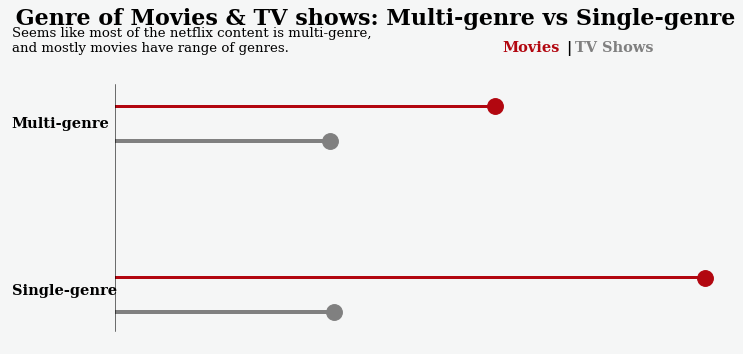

In [87]:
fig, ax = plt.subplots(figsize = (10,5), dpi = 80)
fig.patch.set_facecolor('#f5f6f6')
ax.set_facecolor('#f5f6f6')

ax.barh( y = [2,2.25], width = tv_multi.values, height = 0.0055, color = 'grey' )
ax.barh(y = [2.05,2.3], width = mv_multi.values,height = 0.0052, color = colors )
ax.scatter(y = [2,2.25], x = tv_multi.values, s = 200, c = 'grey' )
ax.scatter(y = [2.05,2.3], x = mv_multi.values, s = 200, c = colors )

ax.axvline(ymin = 0.05, ymax = 0.85, x = 0, **{'linewidth':0.5},color = 'black',alpha = 1)



ax.text(-590,2.42, ' Genre of Movies & TV shows: Multi-genre vs Single-genre', {'font':'serif','weight':'bold','size':20})
ax.text(-570,2.38, 'Seems like most of the netflix content is multi-genre, \nand mostly movies have range of genres.', {'font':'serif','size':12})

ax.text(-570,2.27, 'Multi-genre', {'font':'serif','size':13, 'weight':'bold'})
ax.text(-570,2.025, 'Single-genre', {'font':'serif','size':13, 'weight':'bold'})



ax.text(2150, 2.38, 'Movies',{'font':'serif', 'size':13, 'color':'#b20710', 'weight':'bold'}, alpha = 1)
ax.text(2500, 2.38, '|',{'font':'serif', 'size':13, 'color':'black','weight':'bold'}, alpha = 1)
ax.text(2550, 2.38, 'TV Shows',{'font':'serif', 'size':13, 'color':'grey', 'weight':'bold'}, alpha = 1)

ax.set_ylim([1.95,2.4])

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

for loc in ['left','right','bottom','top']:
    ax.spines[loc].set_visible(False)



fig.show()


Duration is another intresting feature to analyze, because most of the tv content is follow season representation, were as movies follow time in minutes. This could help us understand user preference of content,whether user like beach watching or short time user.

In [88]:
duration = df.duration.value_counts()

dur_TV_coun = {}
dur_Movi_coun = {}

for idx,val in duration.items():
    l = idx.split(' ')
    if l[1] == 'Season' or l[1] == 'Seasons':
        d = {idx.split(' ')[0] : val}
        dur_TV_coun.update(d)
    else:
        d = {idx.split(' ')[0] : val}
        dur_Movi_coun.update(d)


### tv duration count data
TV_duration, TV_count = [],[]
for idx, val in dur_TV_coun.items():
    TV_duration.append(idx)
    TV_count.append(val)

TV_duration_temp = (pd.DataFrame({'TV_duration': TV_duration, 'TV_count': TV_count})
        .sort_values('TV_count', ascending = False))

TV_duration_temp.reset_index(drop = True, inplace = True)
   
    
### movies duration count data

Movie_duration, Movie_count = [],[]
for idx, val in dur_Movi_coun.items():
    Movie_duration.append(idx)
    Movie_count.append(val)

Movie_duration_temp = (pd.DataFrame({'Movie_duration': Movie_duration, 'Movie_count': Movie_count})
        .sort_values('Movie_count', ascending = False))

Movie_duration_temp.reset_index(drop = True, inplace = True)



Movie_duration_temp['Movie_duration'] = Movie_duration_temp['Movie_duration'].astype('int64')
Movie_duration_temp['Movie_category'] = pd.cut(Movie_duration_temp['Movie_duration'], 
                                               bins = [0,30,60,90,120,150,180,210,240, 2000],
                                               labels = ['below 30 mins', 'between 30 and 60 mins',
                                                         'between 60 and 90 mins' ,
                                                         'between 90 and 120 mins',
                                                         'between 120 and 150 mins',
                                                         'between 150 and 180 mins',
                                                         'between 210 and 240 mins',
                                                         'between 240 and 1000 mins',
                                                         'above 1000 mins'])

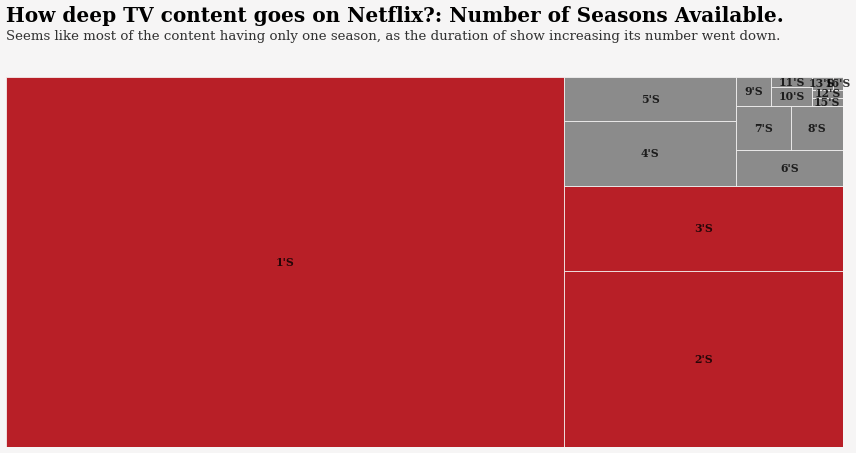

In [97]:
# squarify

TV_duration_temp['color'] = TV_duration_temp['TV_count'].apply(lambda x : '#b20710' if x > TV_duration_temp['TV_count'].sort_values()[3] else 'grey')
# visulaization
fig, ax = plt.subplots(figsize = (18,8), dpi = 60)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

bar_kawrgs = {'edgecolor':'#f6f5f5'}
# Ensure that the number of labels matches the number of bars
labels = [f"{duration}'S" for duration in TV_duration_temp['TV_duration'][0:24]]

# Plot the squarify chart with the correct number of labels
squarify.plot(sizes=TV_duration_temp['TV_count'][0:34], 
              label=labels, 
              ax=ax, 
              color=TV_duration_temp['color'],  **bar_kawrgs ,
              text_kwargs={'font':'serif', 'size':13, 'color':'black', 'weight':'bold', 'alpha':0.8}, 
              alpha=0.9)

# Continue with the rest of your code...

ax.text(0,115,'How deep TV content goes on Netflix?: Number of Seasons Available. ',{'font':'serif', 'size':24, 'color':'black', 'weight':'bold'}, alpha = 1)
ax.text(0,110, 'Seems like most of the content having only one season, as the duration of show increasing its number went down.',
       {'font':'serif', 'size':16, 'color':'black'}, alpha = 0.8)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

for loc in ['left','right','top', 'bottom']:
    ax.spines[loc].set_visible(False)

fig.show()

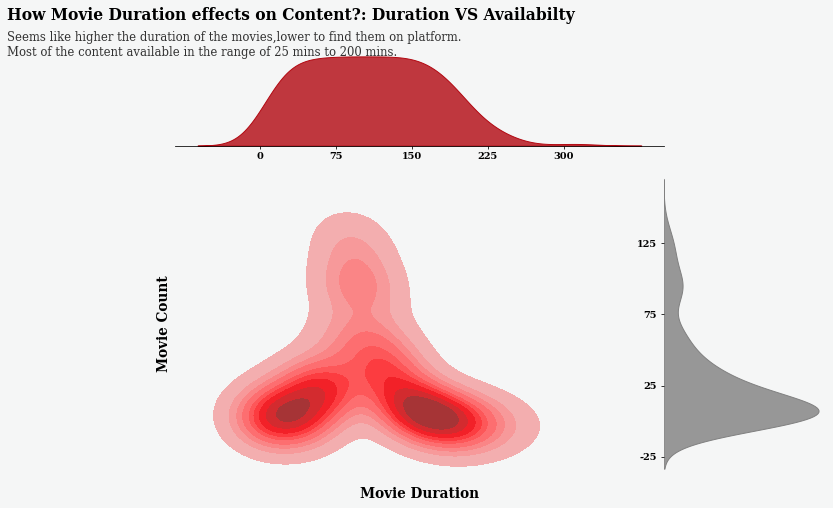

In [143]:
fig = plt.figure(figsize = (12,8), dpi = 70)

fig.patch.set_facecolor('#f5f6f6')

gs = fig.add_gridspec(4,4)
gs.update(wspace = 0., hspace = 0.2)

ax1 = fig.add_subplot(gs[0 ,0:3])
ax2 = fig.add_subplot(gs[1:4,0:3])
ax3 = fig.add_subplot(gs[1:4, 3:4])


axes = [ax1, ax2, ax3]

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    for loc in ['left', 'right', 'top','bottom']:
        ax.spines[loc].set_visible(False)

ax2.axes.get_xaxis().set_visible(True)
ax2.axes.get_yaxis().set_visible(True)
ax1.axes.get_xaxis().set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax3.axes.get_yaxis().set_visible(True)
ax1.spines['bottom'].set_visible(True)
sns.kdeplot( x = 'Movie_duration',data = Movie_duration_temp, ax = ax1, shade = True, color = colors[0], alpha = 0.8)
sns.kdeplot( y = 'Movie_count', data = Movie_duration_temp, ax = ax3, shade = True, color = 'grey', alpha = 0.8)
sns.kdeplot( x = 'Movie_duration', y = 'Movie_count', data = Movie_duration_temp, ax =ax2, color = colors[0], shade  = True)

ax2.set_xlabel('Movie Duration',{'font':'serif', 'size':14, 'weight':'bold', })
ax2.set_ylabel('Movie Count',{'font':'serif', 'size':14, 'weight':'bold', })
ax3.set_ylabel('')
ax1.set_xlabel('')
ax2.set_xticks(ticks = [])
ax2.set_yticks(ticks = [])

ax1.set_xticks(ticks = np.arange(0, 350, 75))
ax1.set_xticklabels(np.arange(0, 350, 75),**{'font':'serif', 'size':10, 'weight':'bold', })
ax3.set_yticks(ticks = np.arange(-25, 150, 50))
ax3.set_yticklabels(np.arange(-25, 150, 50),**{'font':'serif', 'size':10, 'weight':'bold', })

ax1.text(-250, 0.0070,'How Movie Duration effects on Content?: Duration VS Availabilty',{'font':'serif', 'size':16, 'weight':'bold', })
ax1.text(-250,0.0050,'Seems like higher the duration of the movies,lower to find them on platform. \nMost of the content available in the range of 25 mins to 200 mins.',
        {'font':'serif', 'size':12, 'weight':'normal'},alpha = 0.8 )
fig.show()


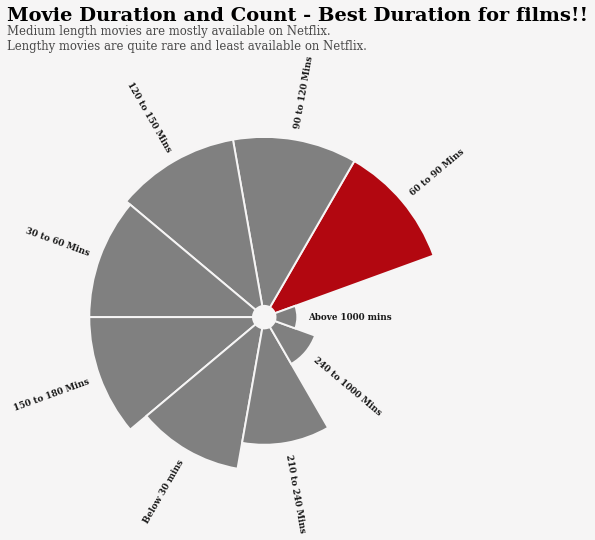

In [151]:
data  = Movie_duration_temp['Movie_category'].value_counts()


# initialize the figure
fig = plt.figure(figsize=(14,7), dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
ax = plt.subplot(polar=True)
plt.axis('off')


labels = ['60 to 90 Mins', '90 to 120 Mins',
         '120 to 150 Mins', '30 to 60 Mins',
          '150 to 180 Mins', 'Below 30 mins',
          '210 to 240 Mins', '240 to 1000 Mins',
          'Above 1000 mins']

colors = ['#b20710', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey','grey']


# Constants = parameters controling the plot layout:
upperLimit = 200
lowerLimit = 2
labelPadding = 2

# Compute max and min in the dataset
max = data.max()

slope = (max - lowerLimit) / max
heights = slope * data.values + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(data.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(data)+1))
angles = [element * width for element in indexes]


# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="#f6f5f5",
    color = colors,
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, labels):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle,
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",**{'font':'serif', 'size':9, 'weight':'bold','color':'black'},alpha = 0.9) 

fig.text(0.25,1.1,'Movie Duration and Count - Best Duration for films!!',{'font':'serif', 'size':20, 'weight':'bold','color':'black'})
fig.text(0.25,1.04 ,'Medium length movies are mostly available on Netflix. \nLengthy movies are quite rare and least available on Netflix.',{'font':'serif', 'size':12,'color':'black'}, alpha = 0.7)
fig.show()


In [152]:
cast = df[['cast', 'type', 'title']]
cast_names = cast['cast']


names_dict = {}

for names in cast_names:
    names = names.split(',')
    for name in names:
        if name in names_dict.keys():
            d = {}
            d[name] = names_dict[name] + 1
            names_dict.update(d)
        else:
            d = {}
            d[name] = 1
            names_dict.update(d)

actor, roles = [], []
for key, value in names_dict.items():
    actor.append(key)
    roles.append(value)
    
cast_temp = (pd.DataFrame({'Actor':actor, 'Roles':roles})
             .sort_values('Roles', ascending = False))
cast_temp.reset_index(drop = True, inplace = True)

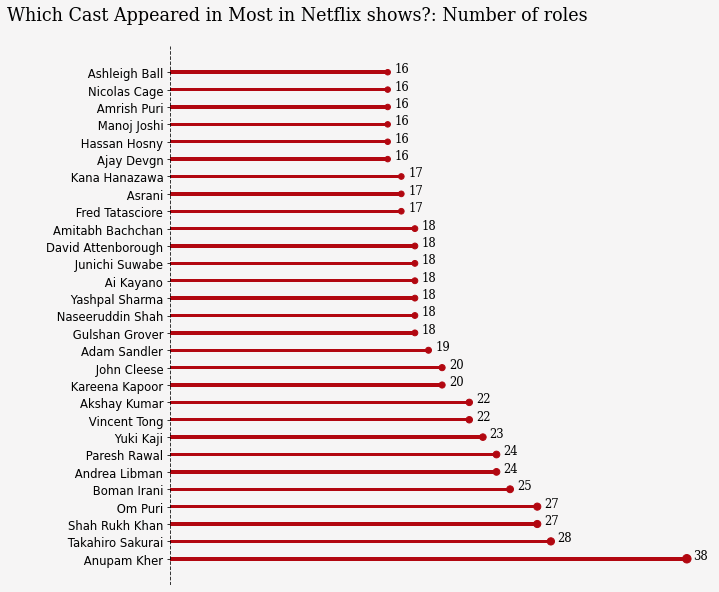

In [154]:
cast_temp = cast_temp.sort_values(by = 'Roles', ascending = False).reset_index(drop = True)
fig,ax = plt.subplots(figsize =(10,10),dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

ax.barh(y = cast_temp.Actor[1:30], width =  cast_temp.Roles[1:30], height = 0.2, color = colors[0])
ax.scatter(y = cast_temp.Actor[1:30], x =  cast_temp.Roles[1:30], s = (cast_temp.Roles[1:30]) *2, c = colors[0] )
ax.axvline(x = 0, ymin = 0,ymax = 1, **{'linewidth':1, 'linestyle':'--', 'color':'black'}, alpha = 0.8)

for i, j in zip(cast_temp.Roles[1:30], cast_temp.Actor[1:30]):
    ax.text(i+0.5,j,i,{'font':'serif', 'size':12,'weight':'bold'})


# Set font properties for the tick labels separately using fontdict
ax.set_yticklabels(cast_temp.Actor[1:30])
ax.tick_params(axis='y', labelsize=12, labelweight='bold', labelcolor='black', labelfont={'fontname': 'serif'})
ax.set_xticklabels(labels = [])
ax.set_xticks(ticks = [])

ax.text(-12, 31, 'Which Cast Appeared in Most in Netflix shows?: Number of roles',{'font':'serif', 'size':18,'weight':'bold'})
plt.box(None)

fig.show()

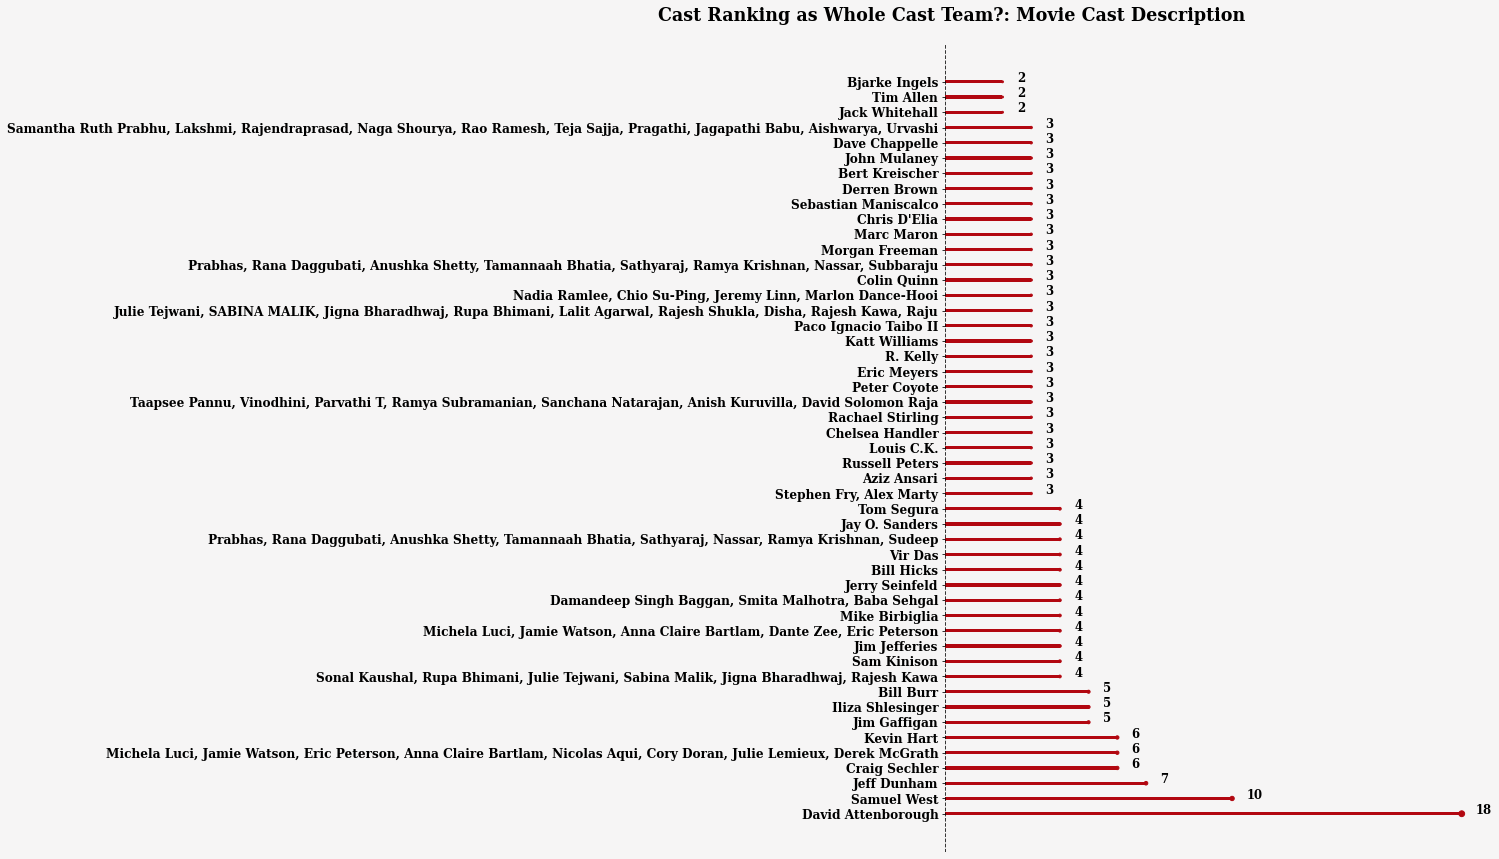

In [114]:
cast_single = cast.cast.value_counts()
x = cast_single[1:50].index,
y = cast_single[1:50].values

fig,ax = plt.subplots(figsize =(10,15),dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

ax.barh(y = range(1,50), width =  y, height = 0.2, color = colors[0])
ax.scatter(y = range(1,50), x =  y, s = (y) *2, c = colors[0] )
ax.axvline(x = 0, ymin = 0,ymax = 1, **{'linewidth':1, 'linestyle':'--', 'color':'black'}, alpha = 0.8)

for i, j in zip(y,range(1,50)):
    ax.text(i+0.5,j,i,{'font':'serif', 'size':12,'weight':'bold'})

ax.set_yticks(ticks = range(1,50))
ax.set_yticklabels(x[0].tolist()[0:50], fontdict={'font':'serif', 'size':12.5,'weight':'bold'})
ax.set_xticklabels(labels = [])
ax.set_xticks(ticks = [])

ax.text(-10, 53, 'Cast Ranking as Whole Cast Team?: Movie Cast Description',{'font':'serif', 'size':18,'weight':'bold'})
plt.box(None)

fig.show()

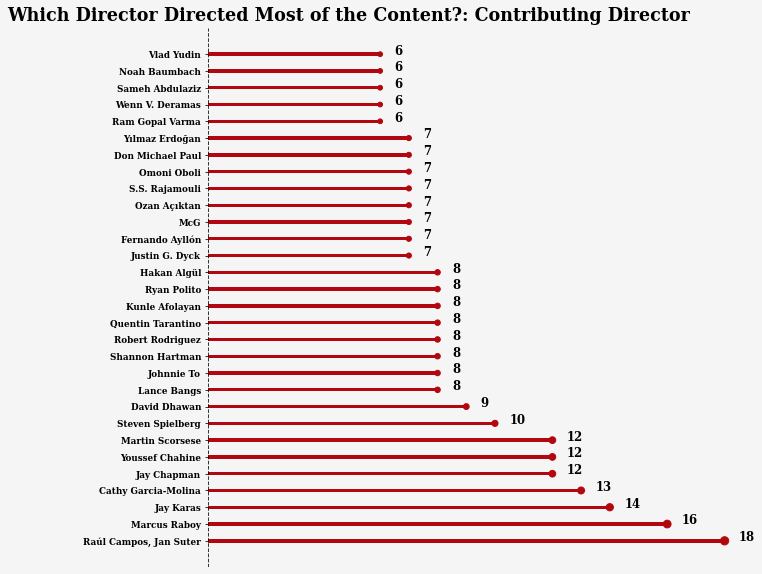

In [116]:
x = df.director.value_counts()[1:31].index,
y = df.director.value_counts()[1:31].values

fig,ax = plt.subplots(figsize =(10,10),dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

ax.barh(y = range(1,31), width =  y, height = 0.2, color = colors[0])
ax.scatter(y = range(1,31), x =  y, s = (y) *4, c = colors[0] )
ax.axvline(x = 0, ymin = 0,ymax = 1, **{'linewidth':1, 'linestyle':'--', 'color':'black'}, alpha = 0.8)

for i, j in zip(y,range(1,31)):
    ax.text(i+0.5,j,i,{'font':'serif', 'size':12,'weight':'bold'})

ax.set_yticks(ticks = range(1,31))
ax.set_yticklabels(x[0].tolist()[0:31], fontdict={'font':'serif', 'size':9,'weight':'bold'})

ax.set_xticklabels(labels = [])
ax.set_xticks(ticks = [])

ax.text(-7, 32, 'Which Director Directed Most of the Content?: Contributing Director',{'font':'serif', 'size':18,'weight':'bold'})
plt.box(None)

fig.show()

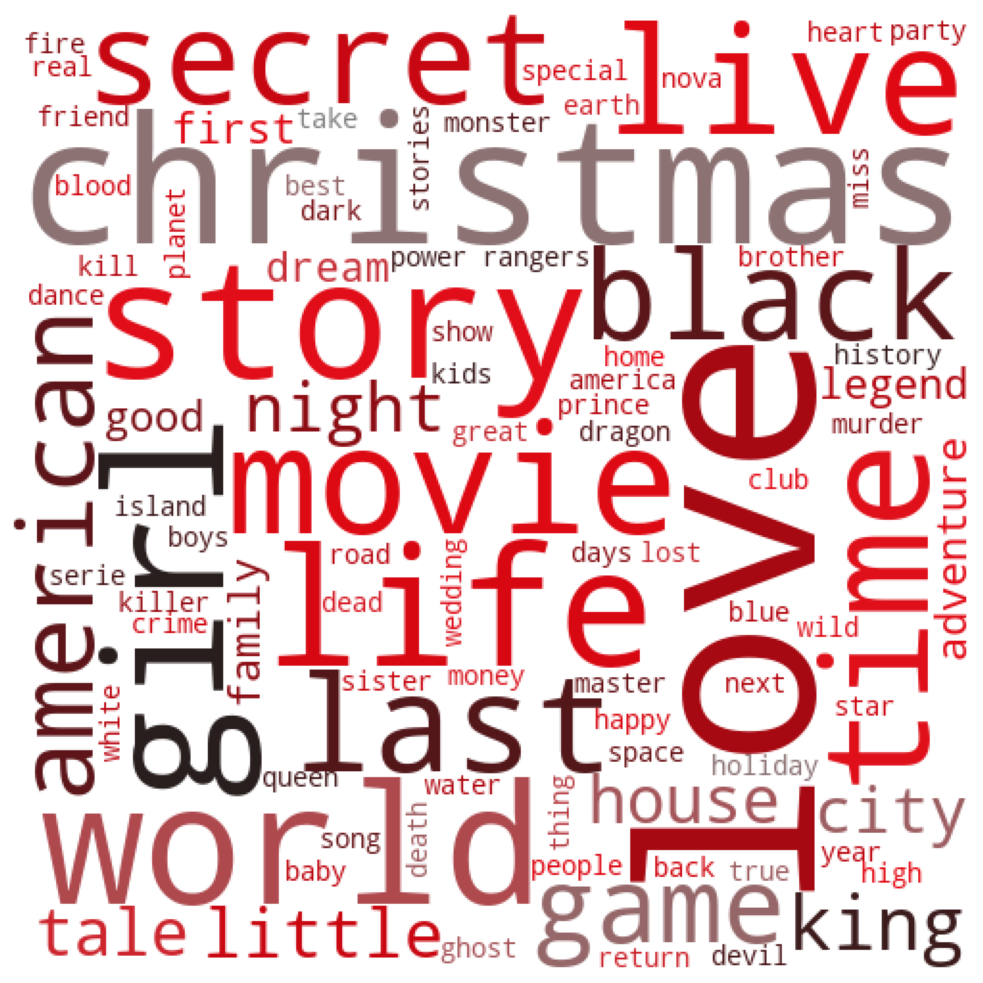

In [155]:
# importing all necessery modules a
from wordcloud import WordCloud, STOPWORDS 

comment_words = '' 
stopwords = set(STOPWORDS) 

for word in df.title:
    words = word.split(',')
    for i in words:
        token = i.lower()
        comment_words += "".join(token) + ' '

colors = ['#221f1f', '#b20710', '#e50914','grey']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors = colors)
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', min_word_length = 4,
                stopwords = stopwords, colormap = colormap,
                min_font_size = 10).generate(comment_words) 

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

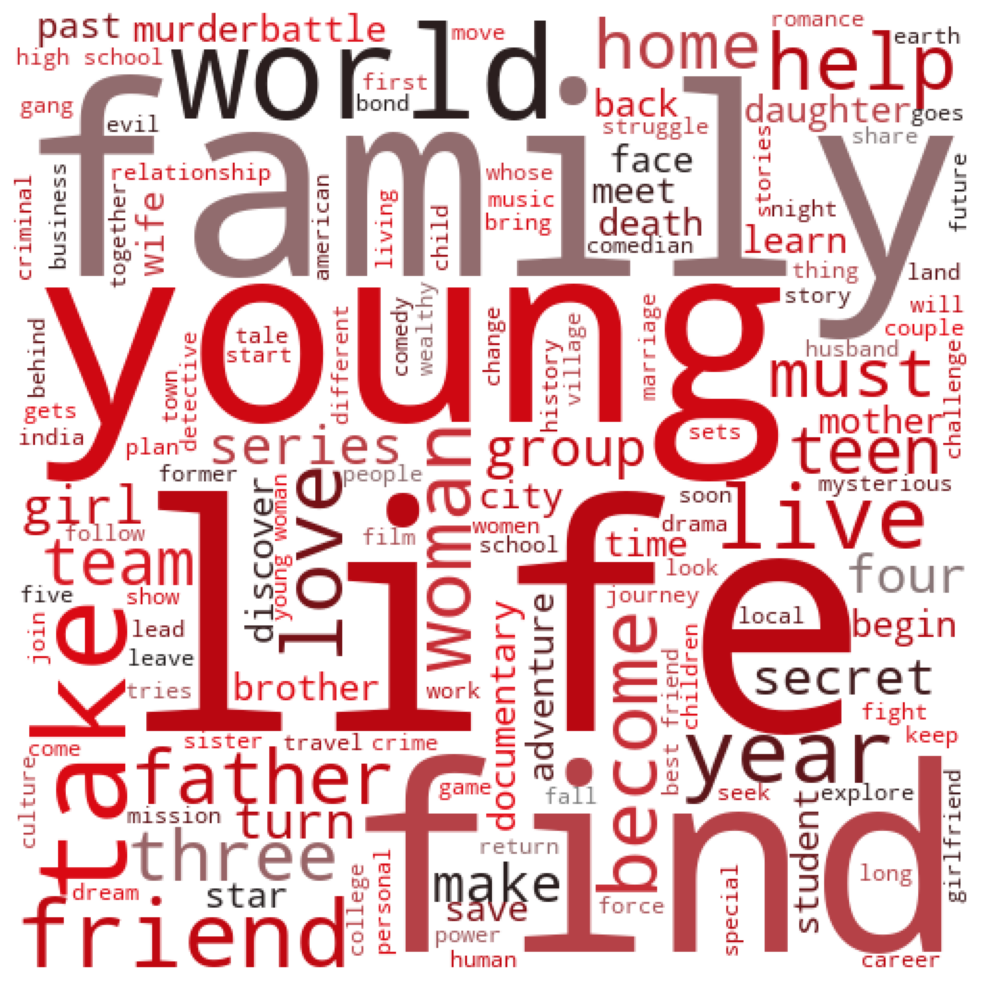

In [156]:
comment_words = '' 
stopwords = set(STOPWORDS) 

for word in df.description:
    words = word.split(',')
    for i in words:
        token = i.lower()
        comment_words += "".join(token) + ' '

wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', min_word_length = 4,
                stopwords = stopwords, colormap = colormap,
                min_font_size = 10).generate(comment_words) 


# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In general recommendation systems are three types

1. Trend based recommendation systems - These are like counting clicks, views per video, upvotes in last few hours.
2. Contet based recommendation systems - These are purely content dependent recommendations, like songs with similar genre, singer, director, location, and soon. we find similarity with in the products or articles here.
3. User-User recommendation systems - These are adoptive systems, which collects huge users data and find correlation between users search trends, activities, watchlists and suggest similar content for simlar kind of users.

To get the completeness of this notebook, Attempting to implement a simple content based recommendation system. Idea is to concactinate the whole content data such as title,director,age-rating, description, country together to create a text corpus of each movie or show. later, vectorize this corpus and pass it through a cosine_similairty method to get the angular distances between various content and create a similarity matrix. Similartity matrix will gives the extent of similarity between each content and sorting and extracting index can give the recommendations

In [158]:
engine_df = df.copy()

content_cols = ['title','type','director','cast','country','listed_in','description','age_rating']
engine_df = engine_df[content_cols]

engine_df['text_content'] = engine_df[['title', 'type', 'director', 'cast', 'country', 'listed_in', 'description', 'age_rating']].apply(lambda x: ' '.join(x), axis=1)


engine_df['text_content'] = engine_df['text_content'].apply(lambda x: x.replace(','," "))
engine_df['text_content'] = engine_df['text_content'].apply(lambda x: x.replace('&'," "))
engine_df['text_content'] = engine_df['text_content'].apply(lambda x: x.replace('-',""))
engine_df['text_content'] = engine_df['text_content'].apply(lambda x: x.replace('.'," "))
engine_df['text_content'] = engine_df['text_content'].apply(lambda x: x.lower())

In [159]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

countvect = CountVectorizer()  ### helps in count in words reperated in the text 
count_matrix = countvect.fit_transform(engine_df['text_content']) ## creates nxn count matrix for all the words in corpus
cosine_sim = cosine_similarity(count_matrix)

In [160]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'



def recommend_me(my_title, n = 10, verbose = True):
    "my_title: Name of the show \
     n: number of recommendations"
    
    if n > 30:
        n = 30
    def get_title_from_index(index):
        return engine_df[engine_df.index == index]['title'].values[0]
    def get_index_from_title(title):
        return engine_df[engine_df['title'] == title].index.values[0]
    
    try:
        index_ = get_index_from_title(my_title)
        similar_movies = list(enumerate(cosine_sim[index_]))
        sorted_similar_movies = (sorted(similar_movies, key = lambda x: x[1], 
                                    reverse = True ))[1:] ## sorting based on second element of tuple and removing self
        recommend = []
        print(bcolors.BOLD + bcolors.WARNING +'Top {} Recommendations for you because you liked {}:'.format(n, my_title) + bcolors.ENDC)
    
        for count,val in enumerate(sorted_similar_movies):
            if count >n:
                break
            recommended_ = get_title_from_index(val[0])
            recommend.append(recommended_)
            if verbose:
                print(bcolors.BOLD + bcolors.OKBLUE + recommended_)
            
    except:
        print(bcolors.BOLD + bcolors.WARNING +'There is no content is available as per your liking. May be give me title available on NETFLIX'+ bcolors.ENDC)
    return None#recommend

In [161]:
recommend_me('Lucifer',10)

Top 10 Recommendations for you because you liked Lucifer:
Marvel's Iron Fist
Killer Ratings
Against the Tide
The Good Cop
Tunnel
Mind Game
Billy on the Street
Dracula
Dramaworld
The Expanding Universe of Ashley Garcia
Dancing Angels


In [162]:
recommend_me('asdfasndnfasdf',10,)

There is no content is available as per your liking. May be give me title available on NETFLIX


In [163]:
recommend_me('The Umbrella Academy',10,)

Top 10 Recommendations for you because you liked The Umbrella Academy:
Haunted
Battlefish
L.A.’s Finest
Colony
A Series of Unfortunate Events
The Bachelorette
The Messengers
Million Pound Menu
I Have a Script
Mighty Little Bheem
Lost in Space
